# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Correlation between dataset features

In [5]:
sales_train.join(items.set_index('item_id'), on='item_id').corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402,0.029128
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230,0.019380
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650,0.369431
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197,-0.253554
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000,0.014768
item_category_id,0.029128,0.019380,0.369431,-0.253554,0.014768,1.000000


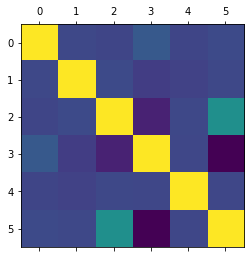

In [6]:
plt.matshow(sales_train.join(items.set_index('item_id'), on='item_id').corr())

Does train dataset contains zeros?

In [7]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

# item_cnt_day

In [8]:
sales_train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

(array([2.934464e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

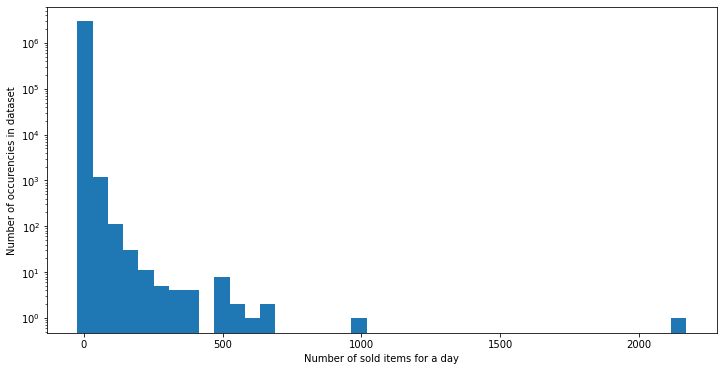

In [9]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

Group number of sold items by date_block and plot.

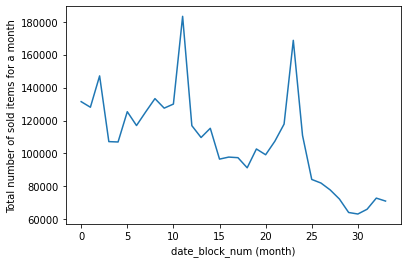

In [10]:
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

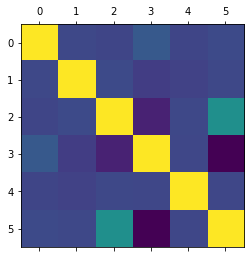

In [11]:
plt.matshow(sales_train.join(items.set_index('item_id'), on='item_id').corr())

There is an obvious trend with peaks at New Year holidays.

# item_price

In [12]:
sales_train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

(array([2.902174e+06, 1.402500e+04, 9.814000e+03, 3.163000e+03,
        4.418000e+03, 2.038000e+03, 1.930000e+02, 1.200000e+01,
        8.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([-1.00000000e+00,  5.13201667e+

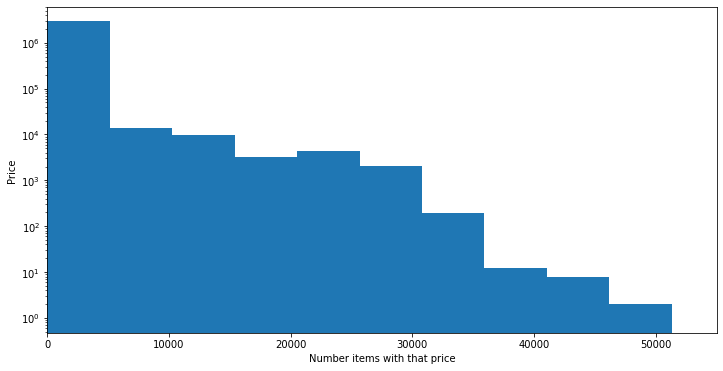

In [13]:
plt.figure(figsize=(12,6))
plt.xlabel('Number items with that price')
plt.xlim(-2, 55000)
plt.ylabel('Price')
plt.yscale('log')
plt.hist(sales_train.item_price, bins=60)

Majority of items has price lower than 5000.

# date_block_num

In [14]:
sales_train.date_block_num.describe()

count    2.935849e+06
mean     1.456991e+01
std      9.422988e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

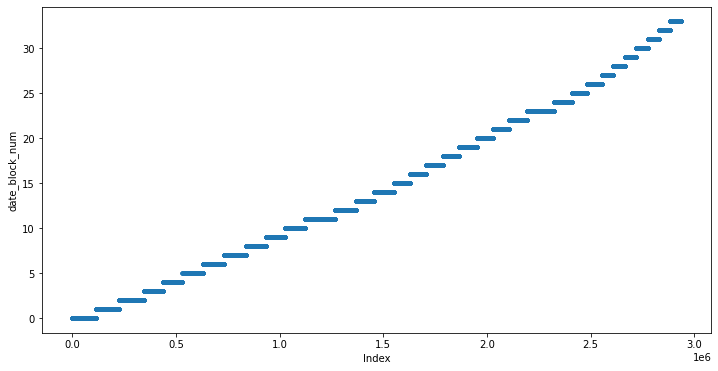

In [15]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

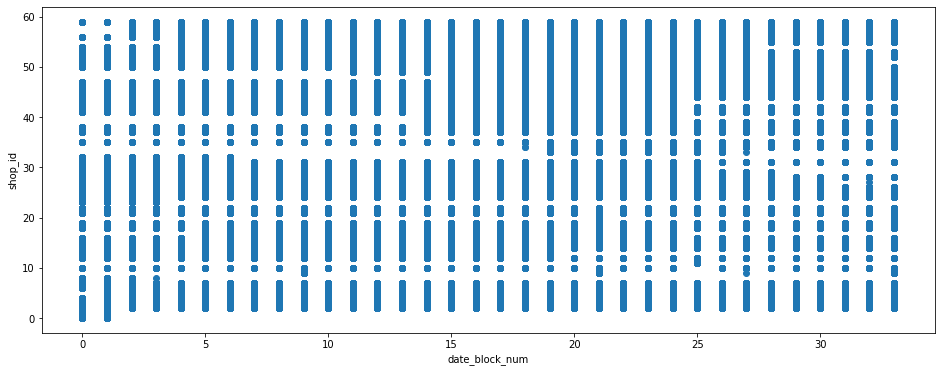

In [16]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix item_price feature

Some of prices may be wrong. Let's find them. At first we look for prices with big difference for each item and find for them the most frequent normal prices.

In [17]:
sales_train.duplicated(subset=['date', 'shop_id', 'item_id']).sum()

28

In [18]:
# for each item get price mode which more than 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)
# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
1837          0.50  2599.0  1999.0   5198.000000

Fix wrong prices

In [19]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
shops_last_prices = sales_train[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', 
                                                                               'item_id']).agg('last')

sales_test = sales_test.join(shops_last_prices, on=['shop_id', 'item_id'])
sales_test.drop('ID', axis=1, inplace=True)

Group dataset by shop, item and date number.

# Group train dataset, investigate data distribution for train and test datasets.

In [20]:
#drop date feature, it's erratic
sales_train.drop('date', axis=1, inplace=True)

sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)


Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

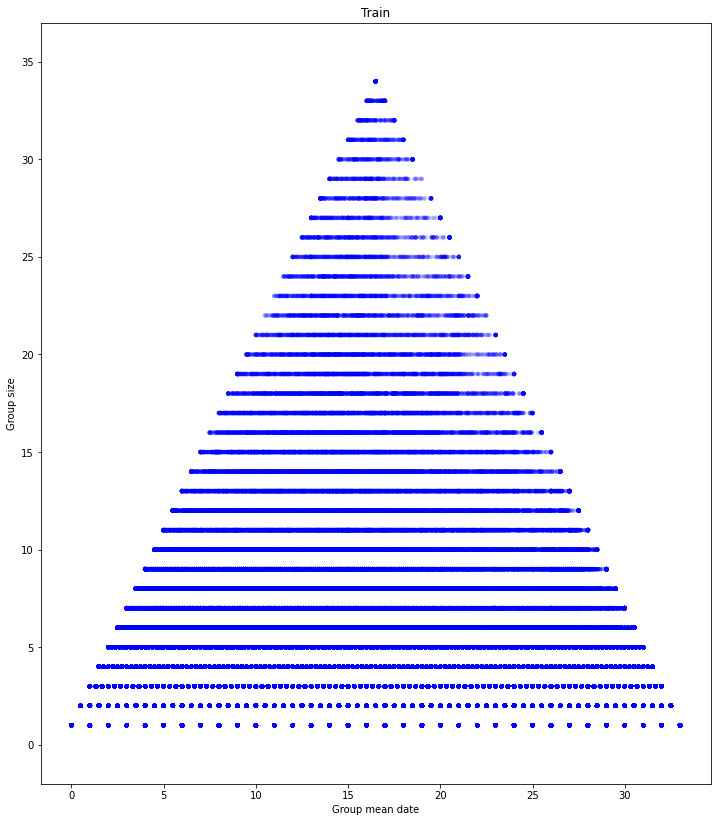

In [21]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.title('Train');

Test dataset

In [22]:
sales_test

,shop_id,item_id,item_price
0,5,5037,749.5
1,5,5320,NaN
2,5,5233,1199.0
3,5,5232,599.0
4,5,5268,NaN
...,...,...,...
214195,45,18454,99.0
214196,45,16188,NaN
214197,45,15757,199.0
214198,45,19648,NaN


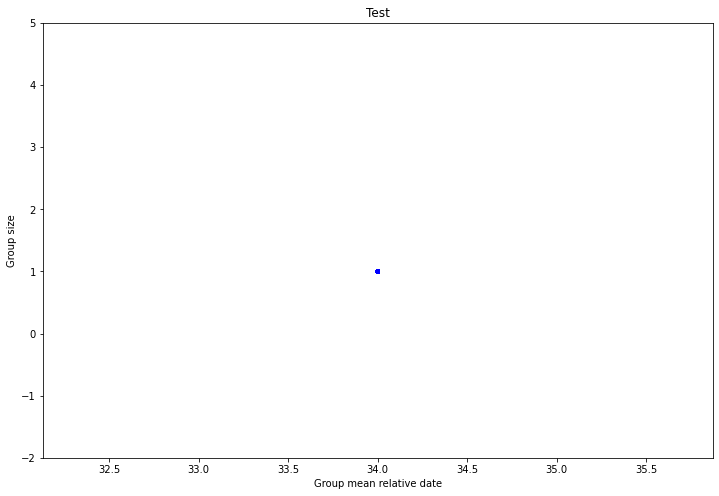

In [23]:
sales_test['date_block_num'] = 34
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For top groups in top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_month feature in our dataset. 

In [24]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629372
Name: item_cnt_day, dtype: int64

So, in train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

Add new dataset to train dataset

In [25]:
sales_test_gr1 = sales_test.loc[~sales_test.item_id.isin(sales_train_gr.item_id)]
sales_test_gr1['item_cnt_month'] = 0

sales_train_gr = pd.concat([sales_train_gr, sales_test_gr1]).sort_values(['shop_id', 
                                                                          'item_id']).reset_index(drop=True)

<ipython-input-25-e9e176a1d20c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_test_gr1['item_cnt_month'] = 0


In [26]:
## in case you want to return previous version
# sales_train_gr1 = sales_train_gr.groupby(['shop_id', 
#                                           'item_id']).agg('mean').unstack().stack(dropna=False).reset_index()

In [27]:
# add all possible combinations for existing shop_id/item_id pair and date_block_num
sales_train_gr1 = sales_train_gr.groupby(['shop_id', 
                                          'item_id']).agg('max').reset_index()

sales_train_gr1 = sales_train_gr1.set_index(['shop_id', 
                                             'item_id', 
                                             'date_block_num']).unstack().stack(dropna=False).reset_index()
# delete rows with items, that are not presented in test dataset
# sales_train_gr1 = sales_train_gr1.loc[sales_train_gr1.item_id.isin(sales_test.item_id)]

# # delete rows with shops, that are not presented in test dataset
# sales_train_gr1 = sales_train_gr1.loc[sales_train_gr1.shop_id.isin(sales_test.shop_id)]

# fill NaN values of item_cnt_month feature with zeros
sales_train_gr1.item_cnt_month.fillna(0, inplace=True)

In [28]:
sales_train_gr2 = pd.concat([sales_train_gr, 
                             sales_train_gr1[sales_train_gr1.item_price.isnull()]]).sort_values(['shop_id', 
                                                                                                 'item_id']).reset_index(drop=True)

sales_train_gr2.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,1,0,30,265.0,31.0
1,0,0,30,NaN,0.0
2,2,0,30,NaN,0.0
3,3,0,30,NaN,0.0
4,4,0,30,NaN,0.0


Distribution of items for each shop

<AxesSubplot:xlabel='shop_id'>

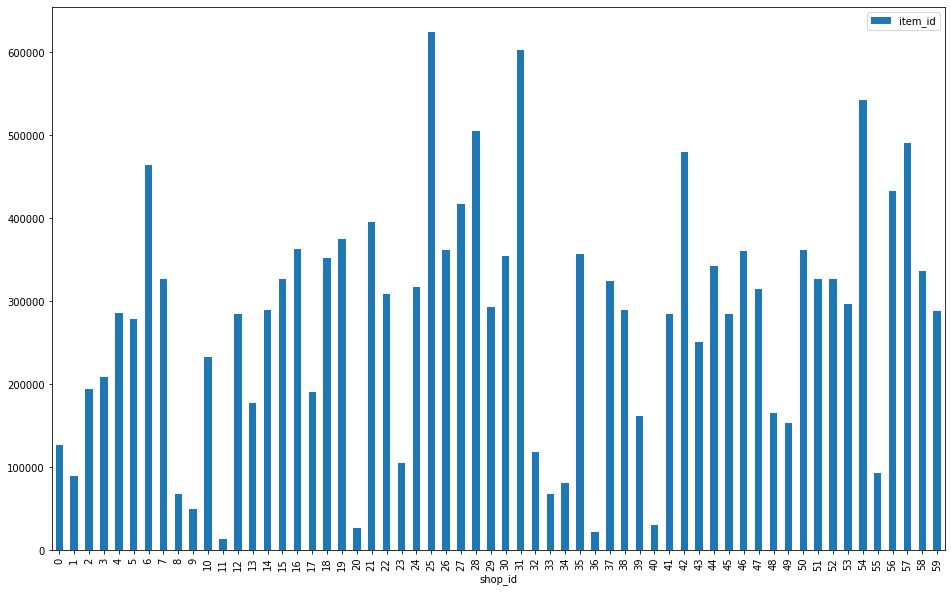

In [29]:
sales_train_gr2.groupby('shop_id').agg({'item_id': 'count'}).plot.bar(figsize=(16, 10))

# Add data from files to train and test datasets

Train dataset

In [30]:
sales_train2 = sales_train_gr2.join(items.set_index('item_id'), on='item_id')
sales_train2 = sales_train2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_train2 = sales_train2.join(shops.set_index('shop_id'), on='shop_id')
# sales_train = sales_train.drop('date_block_num', axis=1)

sales_train2.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name
0,1,0,30,265.0,31.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,30,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
2,2,0,30,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,3,0,30,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,4,0,30,NaN,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"


Test dataset

In [31]:
sales_test2 = sales_test.join(items.set_index('item_id'), on='item_id')
sales_test2 = sales_test2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_test2 = sales_test2.join(shops.set_index('shop_id'), on='shop_id')

sales_test2.head()

,shop_id,item_id,item_price,date_block_num,item_name,item_category_id,item_category_name,shop_name
0,5,5037,749.5,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,5,5320,NaN,34,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,5,5233,1199.0,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,5,5232,599.0,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад"""
4,5,5268,NaN,34,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад"""


Add expert features

In [32]:
def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Цифровой':
        return 'Цифровой склад'
    if city[0] == 'Выездная':
        return 'Выездная Торговля'
    return city[0]

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

def add_holidays(col):
    if np.isnan(col):
        -1
    if col == 1 or col == 5:
        return 1
    return 0

def add_int_part(col):
    if np.isnan(col):
        return np.nan
    return divmod(col, 100)[0]

def add_fract_part(col):
    if np.isnan(col):
        return np.nan
    return divmod(col, 100)[1]

def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

# define if item is material thing
def is_material(col):
    material_list = ['Развитие', 'Аксессуары', 'Гаджеты', 'консоли', 'Открытки', 'Cувениры', 
                     'Настольные игры', 'Мягкие игрушки', 'Гарнитуры', 'Элементы','Комиксы',
                     'Фигурки', 'Атрибутика', 'Сумки', 'литература', 'Путеводители', 'Артбуки']
    for i in material_list:
        if i in col:
            return 1
    return 0
        
 # define if item is service
def is_service(col):
    service_list = ['Доставка товара', 'Служебные', 'Подарки - Сертификаты, услуги']
    if col in service_list:
        return 1
    return 0   
    
month_dict = {1: 31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

    
def create_expert_features(data):
    # add expert features
    data['price_int'] = data.item_price.apply(add_int_part) 
    data['price_fract'] = data.item_price.apply(add_fract_part) 
    data['month'] = data.date_block_num.apply(add_month) 
    data['year'] = data.date_block_num.apply(add_year) 
    data['city'] = data.shop_name.apply(add_city) 
    data['season'] = data.month.apply(add_season) 
    data['has_holidays'] = data.month.apply(add_holidays) 
    data['global_category'] = data.item_category_name.apply(add_global_category)
    data['is_material'] = data.item_category_name.apply(is_material)
    data['is_service'] = data.item_category_name.apply(is_service)
    # add number of days in each month
    data['days_in_month'] = np.nan
    for m in month_dict.keys():
        data.loc[data.month == m, 'days_in_month'] = month_dict[m]

Additional features

In [33]:
def create_col_with_min_freq(data, col, min_freq=10, test=False):
    # replace rare values (less than min_freq rows) in feature by RARE_VALUE
    data[col + '_fixed'] = data[col].astype(str)
    if test is False or col != 'item_name':
        data.loc[sales_train2[col].value_counts()[data[col + '_fixed']].values < min_freq, col + 
                 '_fixed'] = "RARE_VALUE"
    
def create_gr_feats(data, test=False):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'city', 'global_category', 'item_id']:
#         create_col_with_min_freq(data, cat_col, 15, test)
        for num_col in ['item_price']:
            for n, f in [('mean', np.mean), ('min', np.nanmin), ('max', np.nanmax)]:
                data[n + '_' + num_col + '_by_' + cat_col] = sales_train2.groupby(cat_col)[num_col].transform(f)
                
    # create features with counts
    for col in ['shop_id', 'item_id', 'item_category_id', 'city', 'global_category', 'item_price']:
        data[col + '_cnt'] = data[col].map(sales_train2[col].value_counts(dropna = False))

Add expert and additional features

In [34]:
%%time

create_expert_features(sales_train2)
create_expert_features(sales_test2)

create_gr_feats(sales_train2)
create_gr_feats(sales_test2)

# # some values of item_name feature in test dataset can't be met in train dataset
# # so we need to add them in values_count for test dataset to prevent error
# train_vc = pd.concat([sales_train2['item_name_fixed'].value_counts(), 
#            sales_test2.loc[~sales_test2['item_name_fixed'].isin(sales_train2['item_name_fixed']), 
#                           'item_name_fixed'].value_counts()])
# train_vc[len(sales_train2['item_name_fixed'].value_counts()):] = 0

# sales_test2.loc[train_vc[sales_test2['item_name_fixed']].values < 15, 'item_name_fixed'] = 'RARE_VALUE'

CPU times: user 1min 42s, sys: 4.69 s, total: 1min 46s
Wall time: 1min 46s


In [35]:
sales_train2[~sales_train2.item_price.isnull()]

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt
0,1,0,30,265.0,31.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран",2.0,65.0,2,2013,Якутск,winter,0,Кино,0,0,28.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.00,399.0,127221,2182,4210300,1043263,6616884,865
35,1,0,31,434.0,11.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран",4.0,34.0,2,2013,Якутск,winter,0,Кино,0,0,28.0,461.619006,13.000000,15653.0,400.055226,22.0,3599.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,518.387881,147.62,699.0,127221,2307,1716791,1043263,6616884,250
70,0,0,32,221.0,6.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран",2.0,21.0,1,2013,Якутск,winter,1,Кино,0,0,31.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,221.330209,70.62,349.0,127221,2587,4210300,1043263,6616884,352
71,1,0,32,221.0,10.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран",2.0,21.0,2,2013,Якутск,winter,0,Кино,0,0,28.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,221.330209,70.62,349.0,127221,2587,4210300,1043263,6616884,352
106,0,0,33,347.0,3.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран",3.0,47.0,1,2013,Якутск,winter,1,Кино,0,0,31.0,461.619006,13.000000,15653.0,400.055226,22.0,3599.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,245.228381,128.20,499.0,127221,2398,1716791,1043263,6616884,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16578123,27,59,22164,699.0,2.0,ЯРОСТЬ (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",6.0,99.0,4,2015,Ярославль,spring,0,Кино,0,0,30.0,826.049473,4.989247,32997.5,400.055226,22.0,3599.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,691.872029,379.62,749.0,287580,1723,1716791,287580,6616884,31262
16578124,30,59,22164,699.0,1.0,ЯРОСТЬ (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",6.0,99.0,7,2015,Ярославль,summer,0,Кино,0,0,31.0,826.049473,4.989247,32997.5,400.055226,22.0,3599.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,691.872029,379.62,749.0,287580,1723,1716791,287580,6616884,31262
16578159,9,59,22167,299.0,1.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,"Ярославль ТЦ ""Альтаир""",2.0,99.0,10,2013,Ярославль,autumn,0,Книги,0,0,31.0,826.049473,4.989247,32997.5,434.149023,42.0,3490.0,826.049473,4.989247,32997.5,369.925386,17.0,3490.0,296.336381,155.00,299.0,287580,2114,117148,287580,567252,177452
16578160,11,59,22167,299.0,2.0,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,49,Книги - Методические материалы 1С,"Ярославль ТЦ ""Альтаир""",2.0,99.0,12,2014,Ярославль,winter,0,Книги,0,0,31.0,826.049473,4.989247,32997.5,434.149023,42.0,3490.0,826.049473,4.989247,32997.5,369.925386,17.0,3490.0,296.336381,155.00,299.0,287580,2114,117148,287580,567252,177452


Fill NaNs, convert integer features to int type, make all columns in train and test datasets in the same order.

In [36]:
sales_test2.head()

,shop_id,item_id,item_price,date_block_num,item_name,item_category_id,item_category_name,shop_name,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt
0,5,5037,749.5,34,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",7.0,49.5,11,2015,Вологда,autumn,0,Игры,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,2142,749808,278032,3405013,542.0
1,5,5320,NaN,34,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",NaN,NaN,11,2015,Вологда,autumn,0,Музыка,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,2371817,278032,3065786,14969072.0
2,5,5233,1199.0,34,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",11.0,99.0,11,2015,Вологда,autumn,0,Игры,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1652,749808,278032,3405013,24969.0
3,5,5232,599.0,34,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",5.0,99.0,11,2015,Вологда,autumn,0,Игры,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1402,564612,278032,3405013,37892.0
4,5,5268,NaN,34,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",NaN,NaN,11,2015,Вологда,autumn,0,Игры,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,266360,278032,3405013,14969072.0


Drop unnecessary columns

In [37]:
sales_train2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)
sales_test2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

Encode text features with label encoder.

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cols = ['city', 'season', 'global_category']
sales_train2[cols] = sales_train2[cols].apply(LabelEncoder().fit_transform)
sales_test2[cols] = sales_test2[cols].apply(LabelEncoder().fit_transform)

In [39]:
# sales_train2.date_block_num.fillna(-1, inplace=True)
# sales_train2.month.fillna(-1, inplace=True)
# sales_train2.year.fillna(-1, inplace=True)
# sales_train2.days_in_month.fillna(-1, inplace=True)

# sales_train2.date_block_num = sales_train2.date_block_num.astype('int')
# sales_train2.month = sales_train2.month.astype('int')
# sales_train2.year = sales_train2.year.astype('int')
# sales_train2.days_in_month = sales_train2.days_in_month.astype('int')
# sales_train2.item_cnt_month = sales_train2.item_cnt_month.astype('int')

# sales_test2.days_in_month = sales_test2.days_in_month.astype('int')

cols = [col for col in sales_train2.columns if col not in ['item_cnt_month']]
sales_train2 = sales_train2[cols + ['item_cnt_month']]
sales_test2 = sales_test2[cols]

In [40]:
sales_train2.isnull().sum()

date_block_num                                0
shop_id                                       0
item_id                                       0
item_price                             14969072
item_category_id                              0
price_int                              14969072
price_fract                            14969072
month                                         0
year                                          0
city                                          0
season                                        0
has_holidays                                  0
global_category                               0
is_material                                   0
is_service                                    0
days_in_month                                 0
mean_item_price_by_shop_id                    0
min_item_price_by_shop_id                     0
max_item_price_by_shop_id                     0
mean_item_price_by_item_category_id           0
min_item_price_by_item_category_id      

In [41]:
sales_test2.isnull().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_price                             102796
item_category_id                            0
price_int                              102796
price_fract                            102796
month                                       0
year                                        0
city                                        0
season                                      0
has_holidays                                0
global_category                             0
is_material                                 0
is_service                                  0
days_in_month                               0
mean_item_price_by_shop_id                  0
min_item_price_by_shop_id                   0
max_item_price_by_shop_id                   0
mean_item_price_by_item_category_id         0
min_item_price_by_item_category_id          0
max_item_price_by_item_category_id

In [42]:
sales_train2.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt,item_cnt_month
0,1,0,30,265.0,40,2.0,65.0,2,2013,29,3,0,7,0,0,28.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,127221,2182,4210300,1043263,6616884,865,31.0
1,0,0,30,NaN,40,NaN,NaN,1,2013,29,3,1,7,0,0,31.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,127221,2182,4210300,1043263,6616884,14969072,0.0
2,2,0,30,NaN,40,NaN,NaN,3,2013,29,1,0,7,0,0,31.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,127221,2182,4210300,1043263,6616884,14969072,0.0
3,3,0,30,NaN,40,NaN,NaN,4,2013,29,1,0,7,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,127221,2182,4210300,1043263,6616884,14969072,0.0
4,4,0,30,NaN,40,NaN,NaN,5,2013,29,1,1,7,0,0,31.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,127221,2182,4210300,1043263,6616884,14969072,0.0


In [43]:
sales_test2.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt
0,34,5,5037,749.5,19,7.0,49.5,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,2142,749808,278032,3405013,542.0
1,34,5,5320,NaN,55,NaN,NaN,11,2015,3,0,0,8,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,2371817,278032,3065786,14969072.0
2,34,5,5233,1199.0,19,11.0,99.0,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1652,749808,278032,3405013,24969.0
3,34,5,5232,599.0,23,5.0,99.0,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1402,564612,278032,3405013,37892.0
4,34,5,5268,NaN,20,NaN,NaN,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,266360,278032,3405013,14969072.0


Dependencies between item_category_id and item_cnt_month

In [44]:
# g = sales_train2[~sales_train2.item_price.isnull()].groupby('item_category_id').agg({'item_cnt_month': ['min', 'max', 'mean', lambda x: x.value_counts(dropna=True).index[0]]})


Dependencies between shop_id and item_cnt_month

In [45]:
# sales_train2[~sales_train2.item_price.isnull()].groupby('shop_id').agg({'item_cnt_month': ['min', 'max', 'mean', lambda x: x.value_counts(dropna=True).index[0]]})

Save files to csv

# Use Light GBM to predict sales

Split datasets by train and test

In [47]:
cols = [col for col in sales_train2.columns if col not in ['item_cnt_month']]

# X = sales_train2.sort_values(['date_block_num', 'shop_id', 'item_id'])

x = sales_train2[cols]
y = sales_train2['item_cnt_month']

del sales_train, sales_train_gr, sales_train_gr1, sales_train_gr2, sales_test
gc.collect()

Set parameters

In [48]:
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.06,
    'verbose': -1,
    'random_state': 42,
}

Use time split series for LGBM

In [54]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

n_folds = 1 # number of folds
period = 12 # period to train for, months
first_date_block = 34 - n_folds # first date of fold split
# folds = TimeSeriesSplit(n_splits=n_folds)
# splits = folds.split(x, y)

y_preds = np.zeros(sales_test2.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = sales_test2.columns
mean_score = []

cat_feats = ['shop_id', 'item_id', 'item_category_id', 'city', 'global_category']

for fold in range(n_folds):
    print('Fold:',fold + 1)
    print(f'First block date is {first_date_block + fold - period}, last block date is {first_date_block + fold - 1}, '
          f'validation block is {first_date_block + fold}')
    train_index = x[
                    (x.date_block_num < first_date_block + fold)].index
    valid_index = x[x.date_block_num == first_date_block + fold].index
    
    X_train, X_valid = x.loc[train_index], x.loc[valid_index]
    y_train, y_valid = y.loc[train_index], y.loc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(parameters, dtrain, valid_sets = dvalid, num_boost_round=500, verbose_eval=50)
    
    feature_importances[f'fold_{fold + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid, num_iteration=clf.best_iteration)
    
    val_score = mean_squared_error(y_pred_valid, y_valid, squared=False)
    print(f'val rmse score is {val_score}')
    mean_score.append(val_score)
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

print('mean rmse score over folds is',np.mean(mean_score))

Fold: 1
First block date is 21, last block date is 32, validation block is 33


/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/alex/.local/lib/python3.8/site-packages/lightgbm/basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city', 'global_category', 'item_category_id', 'item_id', 'shop_id']
  warnings.warn('categorical_feature in Dataset is overridden.\n'


[50]	valid_0's rmse: 3.39367
[100]	valid_0's rmse: 3.36585
[150]	valid_0's rmse: 3.31542
[200]	valid_0's rmse: 3.29024
[250]	valid_0's rmse: 3.27998
[300]	valid_0's rmse: 3.27764


KeyboardInterrupt: 

In [53]:
sales_train2[sales_train2.date_block_num == 34]

,date_block_num,shop_id,item_id,item_price,item_category_id,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt,item_cnt_month
34,34,0,30,NaN,40,NaN,NaN,11,2015,29,0,0,7,0,0,30.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.00,399.0,127221,2182,4210300,1043263,6616884,14969072,0.0
69,34,0,31,NaN,37,NaN,NaN,11,2015,29,0,0,7,0,0,30.0,461.619006,13.000000,15653.0,400.055226,22.0,3599.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,518.387881,147.62,699.0,127221,2307,1716791,1043263,6616884,14969072,0.0
105,34,0,32,NaN,40,NaN,NaN,11,2015,29,0,0,7,0,0,30.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,221.330209,70.62,349.0,127221,2587,4210300,1043263,6616884,14969072,0.0
141,34,0,33,NaN,37,NaN,NaN,11,2015,29,0,0,7,0,0,30.0,461.619006,13.000000,15653.0,400.055226,22.0,3599.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,245.228381,128.20,499.0,127221,2398,1716791,1043263,6616884,14969072,0.0
177,34,0,35,NaN,40,NaN,NaN,11,2015,29,0,0,7,0,0,30.0,461.619006,13.000000,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,377.840667,148.00,399.0,127221,1503,4210300,1043263,6616884,14969072,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16578046,34,59,22154,NaN,37,NaN,NaN,11,2015,30,0,0,7,0,0,30.0,826.049473,4.989247,32997.5,400.055226,22.0,3599.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,696.576923,299.00,999.0,287580,936,1716791,287580,6616884,14969072,0.0
16578081,34,59,22155,NaN,37,NaN,NaN,11,2015,30,0,0,7,0,0,30.0,826.049473,4.989247,32997.5,400.055226,22.0,3599.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,162.477353,65.00,749.0,287580,1122,1716791,287580,6616884,14969072,0.0
16578120,34,59,22162,NaN,40,NaN,NaN,11,2015,30,0,0,7,0,0,30.0,826.049473,4.989247,32997.5,223.436335,11.0,1399.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,368.407677,28.00,399.0,287580,1767,4210300,287580,6616884,14969072,0.0
16578158,34,59,22164,NaN,37,NaN,NaN,11,2015,30,0,0,7,0,0,30.0,826.049473,4.989247,32997.5,400.055226,22.0,3599.0,826.049473,4.989247,32997.5,338.886696,11.0,7999.0,691.872029,379.62,749.0,287580,1723,1716791,287580,6616884,14969072,0.0


In [52]:
sales_test2.head()

,date_block_num,shop_id,item_id,item_price,item_category_id,price_int,price_fract,month,year,city,season,has_holidays,global_category,is_material,is_service,days_in_month,mean_item_price_by_shop_id,min_item_price_by_shop_id,max_item_price_by_shop_id,mean_item_price_by_item_category_id,min_item_price_by_item_category_id,max_item_price_by_item_category_id,mean_item_price_by_city,min_item_price_by_city,max_item_price_by_city,mean_item_price_by_global_category,min_item_price_by_global_category,max_item_price_by_global_category,mean_item_price_by_item_id,min_item_price_by_item_id,max_item_price_by_item_id,shop_id_cnt,item_id_cnt,item_category_id_cnt,city_cnt,global_category_cnt,item_price_cnt
0,34,5,5037,749.5,19,7.0,49.5,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,2142,749808,278032,3405013,542.0
1,34,5,5320,NaN,55,NaN,NaN,11,2015,3,0,0,8,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,2371817,278032,3065786,14969072.0
2,34,5,5233,1199.0,19,11.0,99.0,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1652,749808,278032,3405013,24969.0
3,34,5,5232,599.0,23,5.0,99.0,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1402,564612,278032,3405013,37892.0
4,34,5,5268,NaN,20,NaN,NaN,11,2015,3,0,0,4,0,0,30.0,461.619006,13.0,15653.0,223.436335,11.0,1399.0,691.994943,4.997661,34990.0,338.886696,11.0,7999.0,262.545138,99.0,399.0,278032,1512,266360,278032,3405013,14969072.0


Features importance

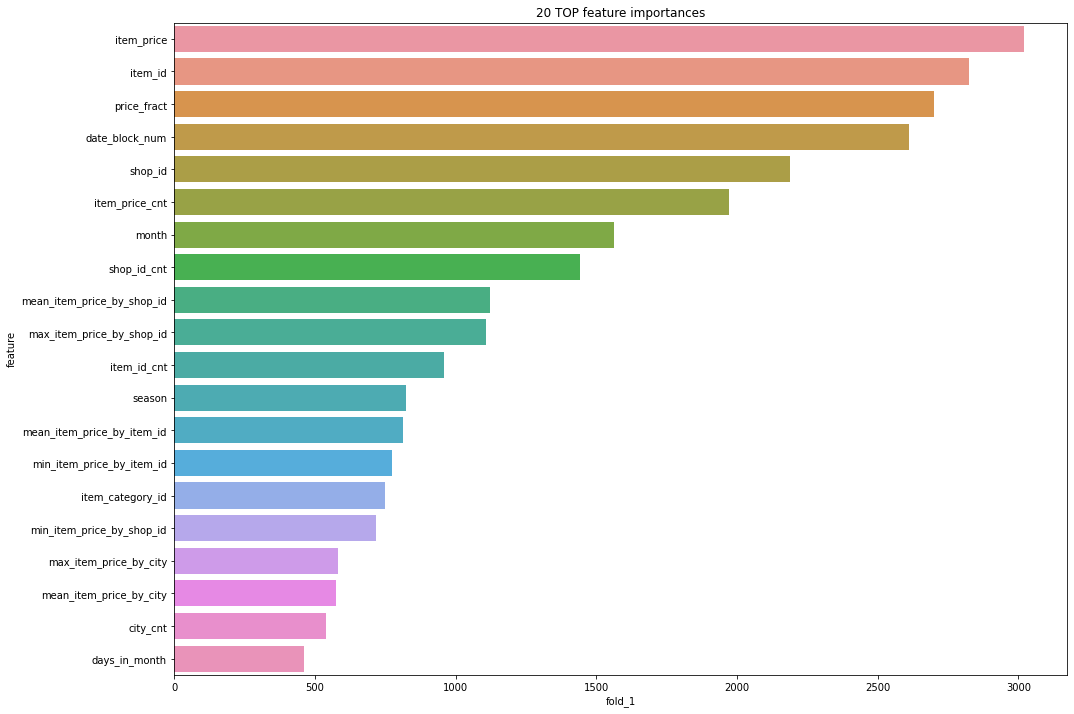

In [50]:
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='fold_1', ascending=False).head(20), x='fold_1', y='feature');
plt.title('20 TOP feature importances');

# Make prediction

In [ ]:
y = clf.predict(sales_test2, num_iteration=clf.best_iteration)

submission['item_cnt_month'] = y
submission.head()

# Save to file

In [ ]:
submission.to_csv('submission.csv', index=False)

# Futher ideas

- use tss for train and test

- drop duplicates

- try TabularAutoML

- replace nan values with -1
- split the price on the integer part and remainder

- split dataset according to most important feature(s)
